In [ ]:

from PIL import Image
import os


directory = '/content/drive/MyDrive/totally_fine_name/new256_images/'
new_dir = '/content/drive/MyDrive/surGANdata/128_images/'
filepaths = []
for dir_, _, files in os.walk(directory):
    for fileName in files:
        #relDir = os.path.relpath(dir_, directory)
        #relFile = os.path.join(relDir, fileName)
        relFile = fileName
        #print(directory)
        #print(relFile)
        filepaths.append(relFile)
        #print(filepaths[-1])

print(filepaths[0])
for i, fp in enumerate(filepaths):
    img = Image.open(directory + fp) #/ 255.0
    img.thumbnail((128, 128), Image.ANTIALIAS)
    img.save(new_dir + str(i) + ".jpg")

1379.jpg


In [1]:
import numpy as np
import os
import PIL
import PIL.Image

import tensorflow as tf

In [14]:
import matplotlib.pyplot as plt

BATCH_SIZE = 32
ce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
weight_init = tf.keras.initializers.RandomNormal(stddev=0.02)
gen_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.999)
dis_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.999)

def generate_image(generator, epoch = 0):
  examples=9
  dim=(3, 3)
  figsize=(3, 3)
  noise = np.random.normal(0, 1, size=[examples, 1, 100])
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(examples, 128, 128, 3)

  plt.figure(figsize=figsize)
  for i in range(generated_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i], interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()
  if not os.path.exists('/content/drive/MyDrive/surGANout'):
    os.mkdir(f'/content/drive/MyDrive/surGANout')
  plt.savefig(f'/content/drive/MyDrive/surGANout/epoch{epoch}.jpg')


def load_data():
  batch_size = 32
  img_height = 128
  img_width = 128
  data_dir = '/content/drive/MyDrive/surGANdata'
  ds = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_height, img_width), batch_size=batch_size)
  return ds

def create_gen():
  m_n = 5 # magical number
  gen = tf.keras.Sequential([
                            tf.keras.layers.Dense(m_n*m_n*576),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Reshape((m_n, m_n, 576)),
                            tf.keras.layers.Conv2DTranspose(filters=288, kernel_size=5, strides=(2, 2), use_bias=False),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Conv2DTranspose(filters=144, kernel_size=5, strides=(2, 2), use_bias=False),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Conv2DTranspose(filters=72, kernel_size=5, strides=(2, 2), use_bias=False),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=8, strides=(2, 2), use_bias=False, activation=tf.keras.activations.tanh)
  ])
  return gen

def create_dis():
  dis = tf.keras.Sequential([
                            tf.keras.layers.Rescaling(1./255),
                            tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=(2, 2)),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=(2, 2)),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=(2, 2)),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=(2, 2)),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(1, activation='sigmoid', name='output')
                            ])
  return dis

def generator_loss(fake_output):
  loss = tf.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
  # print('gen loss is', loss)
  return loss

def discriminator_loss(real_output, fake_output):
  real_loss =  tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
  fake_loss =  tf.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  # print('dis-real loss is', real_loss, 'dis-fake loss is', fake_loss)
  return total_loss, real_loss, fake_loss

def save_models(gen, dis, epoch):
  tf.keras.models.save_model(
      gen,
      f'/content/drive/MyDrive/surGANout/models/generator_{epoch}.model',
      overwrite=True,
      include_optimizer=True,
      save_format=None,
      signatures=None,
      options=None
  )
  tf.keras.models.save_model(
      dis,
      f'/content/drive/MyDrive/surGANout/models/discriminator_{epoch}.model',
      overwrite=True,
      include_optimizer=True,
      save_format=None,
      signatures=None,
      options=None
  )

@tf.function
def perform_train_step(real_images, generator, discriminator, m):
  noise = np.random.normal(0, 1, size=[len(real_images), 1, 100])
  
  with tf.GradientTape() as dis_tape, tf.GradientTape() as gen_tape:
    # generate images
    generated_images = generator(noise, training = True)
    # discriminate generated and real images
    discr_reals = discriminator(real_images, training=True)
    discr_fakes = discriminator(generated_images, training=True)
    # accuracy metric
    m.reset_state()
    m.update_state(tf.ones(tf.shape(discr_reals)), discr_reals)
    a_r = m.result()
    m.reset_state()
    m.update_state(tf.zeros(tf.shape(discr_fakes)), discr_fakes)
    a_f = m.result()
    # compute losses
    gen_loss = generator_loss(discr_fakes)
    dis_loss, d_r, d_f = discriminator_loss(discr_reals, discr_fakes)
  # compute gradinents
  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  dis_gradients = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
  # optimize models
  # gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  dis_optimizer.apply_gradients(zip(dis_gradients, discriminator.trainable_variables))
  # return losses
  return (gen_loss, dis_loss, d_r, d_f, a_r, a_f)

def train_gan(num_epochs, image_data, generator, discriminator):
  hist = {'gen_loss': [], 'dis_real_loss': [], 'dis_fake_loss': [], 'acc_true': [], 'acc_fake': [], 'dis_weights': []}
  m = tf.keras.metrics.Accuracy()
  for epoch_no in range(1, num_epochs+1):
    num_batches = image_data.__len__()
    print(f'Starting epoch {epoch_no}...')
    for batch in image_data:
      gen_loss, dis_loss, d_r, d_f, a_r, a_f = perform_train_step(batch[0], generator, discriminator, m)
    if epoch_no % 40 == 0 or epoch_no == 1:
      generate_image(generator, epoch_no)
      save_models(generator, discriminator, epoch_no)
    hist['gen_loss'].append(gen_loss[0].numpy().mean())
    hist['dis_real_loss'].append(d_r[0].numpy().mean())
    hist['dis_fake_loss'].append(d_f[0].numpy().mean())
    hist['acc_true'].append(a_r.numpy())
    hist['acc_fake'].append(a_f.numpy())
    hist['dis_weights'].append(discriminator.layers[-1].weights)
  print('Run finished')
  return hist


def run_gan(num_epochs=1):
  data = load_data()

  gen = create_gen()
  dis = create_dis()

  print('training GAN...')
  history = train_gan(num_epochs, data, gen, dis)

  # smhw return history of losses
  return gen, dis, history
  



In [12]:
data = load_data()

gen = create_gen()
dis = create_dis()


Found 2379 files belonging to 1 classes.


In [4]:
m = tf.keras.metrics.Accuracy()

In [15]:
for i in range(10000):
  for batch in data:
    gen_loss, dis_loss, d_r, d_f, a_r, a_f = perform_train_step(batch[0], gen, dis, m)
    print(a_r, a_f)
    break

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0625, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.21875, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.46875, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.78125, shape=(), 

KeyboardInterrupt: ignored

In [7]:
dis

Found 2379 files belonging to 1 classes.
training GAN...
Starting epoch 1...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Assets written to: /content/drive/MyDrive/surGANout/models/generator_1.model/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/surGANout/models/discriminator_1.model/assets
Starting epoch 2...
Starting epoch 3...
Starting epoch 4...
Starting epoch 5...
Starting epoch 6...
Starting epoch 7...
Starting epoch 8...
Starting epoch 9...
Starting epoch 10...
Starting epoch 11...
Starting epoch 12...
Starting epoch 13...
Starting epoch 14...
Starting epoch 15...
Starting epoch 16...
Starting epoch 17...
Starting epoch 18...
Starting epoch 19...
Starting epoch 20...
Starting epoch 21...
Starting epoch 22...
Starting epoch 23...
Starting epoch 24...
Starting epoch 25...
Starting epoch 26...
Starting epoch 27...
Starting epoch 28...
Starting epoch 29...
Starting epoch 30...
Starting epoch 31...
Starting epoch 32...
Starting epoch 33...
Starting epoch 34...
Starting epoch 35...
Starting epoch 36...
Starting epoch 37...
Starting epoch 38...
Starting epoch 39...
Starti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Assets written to: /content/drive/MyDrive/surGANout/models/generator_40.model/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/surGANout/models/discriminator_40.model/assets
Run finished


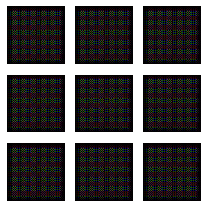

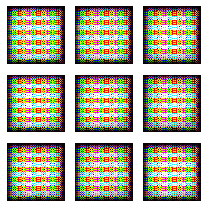

In [ ]:
gen, dis, hist = run_gan(40)

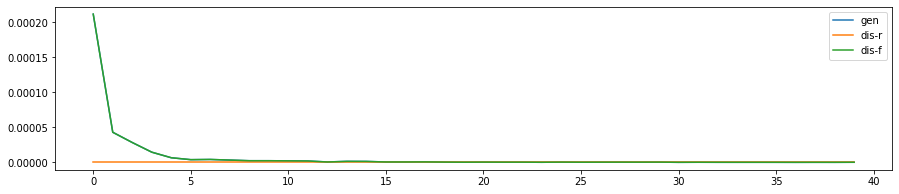

In [ ]:

plt.figure(figsize=(15, 3))
plt.plot(hist['gen_loss'], label='gen')
plt.plot(hist['dis_real_loss'], label='dis-r')
plt.plot(hist['dis_fake_loss'], label='dis-f')
plt.legend()
plt.show()

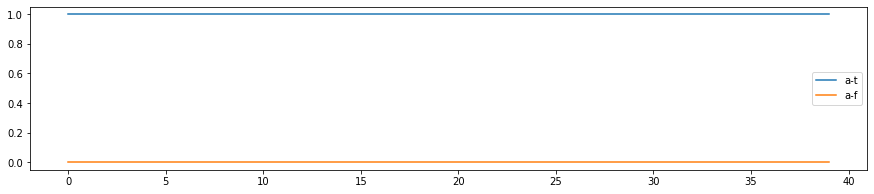

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(hist['acc_true'], label='a-t')
plt.plot(hist['acc_fake'], label='a-f')
plt.legend()
plt.show()

In [ ]:
dis.layers[-1].weights

[<tf.Variable 'output/kernel:0' shape=(6400, 1) dtype=float32, numpy=
 array([[ 0.03438624],
        [-0.01669069],
        [ 0.02298727],
        ...,
        [ 0.03382892],
        [-0.02977669],
        [ 0.02983561]], dtype=float32)>,
 <tf.Variable 'output/bias:0' shape=(1,) dtype=float32, numpy=array([0.00214226], dtype=float32)>]

In [ ]:
m = tf.keras.Sequential([
                            tf.keras.layers.Rescaling(1./255),
                            tf.keras.layers.Conv2D(filters=96, kernel_size=5, strides=(2, 2)),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Conv2D(filters=192, kernel_size=5, strides=(2, 2)),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Conv2D(filters=384, kernel_size=5, strides=(2, 2)),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Conv2D(filters=768, kernel_size=5, strides=(2, 2)),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(1, activation='sigmoid', name='output')
                            ])
m.build(input_shape=(32, 128, 128, 3))
m.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (32, 128, 128, 3)         0         
                                                                 
 conv2d_34 (Conv2D)          (32, 62, 62, 96)          7296      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (32, 62, 62, 96)          0         
                                                                 
 dropout_6 (Dropout)         (32, 62, 62, 96)          0         
                                                                 
 conv2d_35 (Conv2D)          (32, 29, 29, 192)         460992    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (32, 29, 29, 192)         0         
                                                                 
 dropout_7 (Dropout)         (32, 29, 29, 192)       

In [ ]:
m_n = 5
m = tf.keras.Sequential([
                            tf.keras.layers.Dense(m_n*m_n*768),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Reshape((m_n, m_n, 768)),
                            tf.keras.layers.Conv2DTranspose(filters=384, kernel_size=5, strides=(2, 2), use_bias=False),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Conv2DTranspose(filters=192, kernel_size=5, strides=(2, 2), use_bias=False),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Conv2DTranspose(filters=96, kernel_size=5, strides=(2, 2), use_bias=False),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=8, strides=(2, 2), use_bias=False, activation=tf.keras.activations.tanh)
  ])
m.build(input_shape=(32, 100))
m.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (32, 19200)               1939200   
                                                                 
 flatten_3 (Flatten)         (32, 19200)               0         
                                                                 
 reshape_3 (Reshape)         (32, 5, 5, 768)           0         
                                                                 
 conv2d_transpose_12 (Conv2D  (32, 13, 13, 384)        7372800   
 Transpose)                                                      
                                                                 
 batch_normalization_9 (Batc  (32, 13, 13, 384)        1536      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (32, 13, 13, 384)        

In [ ]:
# working dis
m = tf.keras.Sequential()
m.add(tf.keras.layers.Conv2D(28, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
m.add(tf.keras.layers.LeakyReLU())
m.add(tf.keras.layers.Dropout(0.5))

m.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=weight_init))
m.add(tf.keras.layers.LeakyReLU())
m.add(tf.keras.layers.Dropout(0.5))

m.add(tf.keras.layers.Flatten())
m.add(tf.keras.layers.Dense(1, kernel_initializer=weight_init, activation='sigmoid'))
m.build(input_shape=(32, 28, 28, 1))
m.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 14, 14, 28)        728       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 28)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 28)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 7, 7, 64)          44864     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)            

In [ ]:
# working gen
m = tf.keras.Sequential()
# Input block
m.add(tf.keras.layers.Dense(7*7*128, use_bias=False, input_shape=(100,), \
  kernel_initializer=weight_init))
m.add(tf.keras.layers.BatchNormalization())
m.add(tf.keras.layers.LeakyReLU())
# Reshape 1D Tensor into 3D
m.add(tf.keras.layers.Reshape((7, 7, 128)))
# First upsampling block
m.add(tf.keras.layers.Conv2DTranspose(56, (5, 5), strides=(1, 1), padding='same', use_bias=False, \
  kernel_initializer=weight_init))
m.add(tf.keras.layers.BatchNormalization())
m.add(tf.keras.layers.LeakyReLU())
# Second upsampling block
m.add(tf.keras.layers.Conv2DTranspose(28, (5, 5), strides=(2, 2), padding='same', use_bias=False, \
  kernel_initializer=weight_init))
m.add(tf.keras.layers.BatchNormalization())
m.add(tf.keras.layers.LeakyReLU())
# Third upsampling block: note tanh, specific for DCGAN
m.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', \
  kernel_initializer=weight_init))
m.build(input_shape=(32, 100))
m.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 6272)              627200    
                                                                 
 batch_normalization_38 (Bat  (None, 6272)             25088     
 chNormalization)                                                
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_13 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_65 (Conv2D  (None, 7, 7, 56)         179200    
 Transpose)                                                      
                                                                 
 batch_normalization_39 (Bat  (None, 7, 7, 56)       